# Import and download


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, recall_score, precision_score, f1_score
from ydata_profiling import ProfileReport

In [2]:
import kagglehub
import os
import pandas as pd

# Download latest version
path = kagglehub.dataset_download("johnjdavisiv/urinary-biomarkers-for-pancreatic-cancer")

print("Path to dataset files:", path)
csv_file = [f for f in os.listdir(path) if f.endswith('.csv')][0]
full_path = os.path.join(path, csv_file)

print(f"Loading file: {full_path}")
df = pd.read_csv(full_path)

Path to dataset files: /kaggle/input/urinary-biomarkers-for-pancreatic-cancer
Loading file: /kaggle/input/urinary-biomarkers-for-pancreatic-cancer/Debernardi et al 2020 data.csv


# EDA and Data preparation


In [3]:
df_profile = ProfileReport(df, title="DF")


In [4]:
df_profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 14/14 [00:00<00:00, 69.55it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [5]:
df.head()

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


sample_id patient_cohort sample_origin  age sex  diagnosis stage  \
0        S1        Cohort1          BPTB   33   F          1   NaN   
1       S10        Cohort1          BPTB   81   F          1   NaN   
2      S100        Cohort2          BPTB   51   M          1   NaN   
3      S101        Cohort2          BPTB   61   M          1   NaN   
4      S102        Cohort2          BPTB   62   M          1   NaN   

  benign_sample_diagnosis  plasma_CA19_9  creatinine     LYVE1      REG1B  \
0                     NaN           11.7     1.83222  0.893219   52.94884   
1                     NaN            NaN     0.97266  2.037585   94.46703   
2                     NaN            7.0     0.78039  0.145589  102.36600   
3                     NaN            8.0     0.70122  0.002805   60.57900   
4                     NaN            9.0     0.21489  0.000860   65.54000   

         TFF1     REG1A  
0  654.282174  1262.000  
1  209.488250   228.407  
2  461.141000       NaN  
3  142.950000       NaN  
4   41.088000       NaN

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590 entries, 0 to 589
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   sample_id                590 non-null    object 
 1   patient_cohort           590 non-null    object 
 2   sample_origin            590 non-null    object 
 3   age                      590 non-null    int64  
 4   sex                      590 non-null    object 
 5   diagnosis                590 non-null    int64  
 6   stage                    199 non-null    object 
 7   benign_sample_diagnosis  208 non-null    object 
 8   plasma_CA19_9            350 non-null    float64
 9   creatinine               590 non-null    float64
 10  LYVE1                    590 non-null    float64
 11  REG1B                    590 non-null    float64
 12  TFF1                     590 non-null    float64
 13  REG1A                    306 non-null    float64
dtypes: float64(6), int64(2), o

In [7]:
df['target'] = df['diagnosis'].apply(lambda x: 1 if x == 3 else 0)

drop_cols = ['sample_id', 'patient_cohort', 'sample_origin', 
             'stage', 'benign_sample_diagnosis', 'diagnosis', 
             'target', 'REG1A']
X = df.drop(columns=drop_cols)
y = df['target']


X['LYVE1_ratio'] = X['LYVE1'] / X['creatinine']
X['REG1B_ratio'] = X['REG1B'] / X['creatinine']
X['TFF1_ratio']  = X['TFF1']  / X['creatinine']


X['LYVE1_x_REG1B'] = X['LYVE1_ratio'] * X['REG1B_ratio']
X['REG1B_x_TFF1']  = X['REG1B_ratio'] * X['TFF1_ratio']

X['sex'] = X['sex'].map({'M': 0, 'F': 1})

# ML

In [8]:
params = {
    'iterations': 1000,
    'learning_rate': 0.03,
    'depth': 5,                 # Неглубокие деревья 
    'loss_function': 'Logloss', # Бинарная классификация
    'eval_metric': 'AUC',
    'auto_class_weights': 'Balanced', # Авто-баланс (раковых меньше, чем здоровых)
    'verbose': 0,
    'allow_writing_files': False,
    'early_stopping_rounds': 50
}

In [9]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scores = {'AUC': [], 'Recall': [], 'Precision': [], 'F1': []}
feature_importance = np.zeros(len(X.columns))

print("Начинаем обучение CatBoost...")

for fold, (train_idx, test_idx) in enumerate(skf.split(X, y)):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    model = CatBoostClassifier(**params)
    
    model.fit(X_train, y_train, eval_set=(X_test, y_test))
    
    
    y_pred = model.predict(X_test)         # Классы (0 или 1)
    y_proba = model.predict_proba(X_test)[:, 1] # Вероятность (0.0 ... 1.0)
    
    # Собираем метрики
    scores['AUC'].append(roc_auc_score(y_test, y_proba))
    scores['Recall'].append(recall_score(y_test, y_pred))
    scores['Precision'].append(precision_score(y_test, y_pred))
    scores['F1'].append(f1_score(y_test, y_pred))
    
    # Копим важность признаков
    feature_importance += model.get_feature_importance()

Начинаем обучение CatBoost...


# General results


=== ИТОГОВЫЕ МЕТРИКИ (Среднее по 5 фолдам) ===
ROC-AUC:   0.9522  (Качество разделения)
Recall:    0.8894  (Найдено больных раком)
Precision: 0.7988  (Точность тревоги)
F1-Score:  0.8413  (Баланс)

ТОП Признаков, указывающих на рак:
          Feature  Importance
2   plasma_CA19_9   47.846306
7     LYVE1_ratio   11.737155
10  LYVE1_x_REG1B    7.965219
4           LYVE1    7.489697
0             age    4.876369
9      TFF1_ratio    4.519015
6            TFF1    4.445662
11   REG1B_x_TFF1    2.874140
8     REG1B_ratio    2.457448
3      creatinine    2.389737


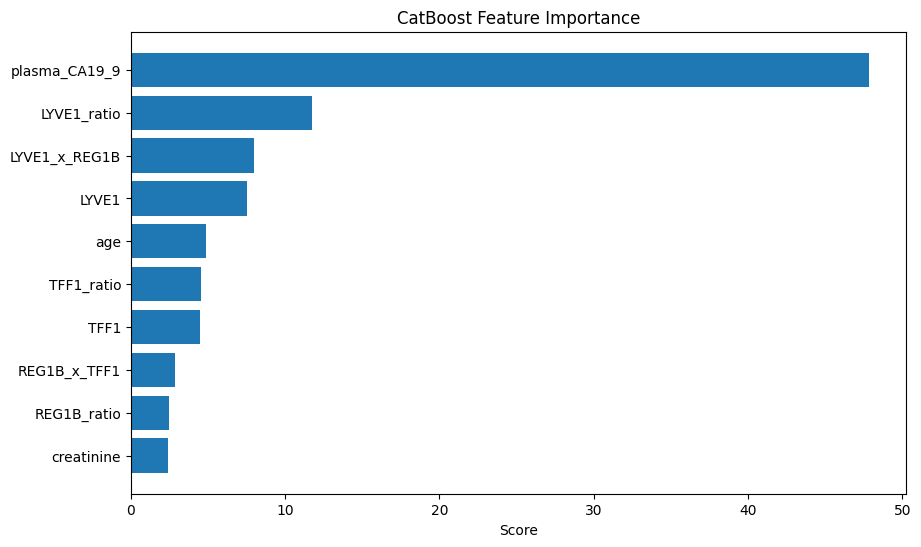

In [10]:
print("\n=== ИТОГОВЫЕ МЕТРИКИ (Среднее по 5 фолдам) ===")
print(f"ROC-AUC:   {np.mean(scores['AUC']):.4f}  (Качество разделения)")
print(f"Recall:    {np.mean(scores['Recall']):.4f}  (Найдено больных раком)")
print(f"Precision: {np.mean(scores['Precision']):.4f}  (Точность тревоги)")
print(f"F1-Score:  {np.mean(scores['F1']):.4f}  (Баланс)")

fi_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importance / 5 # Усредняем
}).sort_values('Importance', ascending=False)

print("\nТОП Признаков, указывающих на рак:")
print(fi_df.head(10))

# График
plt.figure(figsize=(10, 6))
plt.barh(fi_df['Feature'][:10][::-1], fi_df['Importance'][:10][::-1], color='#1f77b4')
plt.title('CatBoost Feature Importance')
plt.xlabel('Score')
plt.show()

## Training on all data

In [11]:
import joblib

print("\n--- Финальное обучение на 100% данных ---")

# Убираем early_stopping, чтобы она доучилась до конца
final_params = params.copy()
if 'early_stopping_rounds' in final_params:
    del final_params['early_stopping_rounds'] # Удаляем ограничение
final_params['verbose'] = 100  # Чтобы видеть прогресс

final_model = CatBoostClassifier(**final_params)

final_model.fit(X, y)

print(f"\nКоличество деревьев: {final_model.tree_count_}") 

joblib.dump(final_model, 'pancreatic_cancer_model_full.joblib')
print("Модель успешно сохранена в 'pancreatic_cancer_model_full.joblib'")


--- Финальное обучение на 100% данных ---
0:	total: 2.58ms	remaining: 2.57s
100:	total: 182ms	remaining: 1.62s
200:	total: 357ms	remaining: 1.42s
300:	total: 527ms	remaining: 1.22s
400:	total: 711ms	remaining: 1.06s
500:	total: 871ms	remaining: 868ms
600:	total: 1.03s	remaining: 686ms
700:	total: 1.2s	remaining: 510ms
800:	total: 1.36s	remaining: 338ms
900:	total: 1.52s	remaining: 167ms
999:	total: 1.68s	remaining: 0us

Количество деревьев: 1000
Модель успешно сохранена в 'pancreatic_cancer_model_full.joblib'


# Build

In [12]:
joblib.dump(final_model, 'pancreatic_cancer_model.joblib')

['pancreatic_cancer_model.joblib']

In [13]:
import joblib
import pandas as pd

loaded_model = joblib.load('pancreatic_cancer_model.joblib')

print(f"Количество деревьев в модели: {loaded_model.tree_count_}")
print(f"Использованные признаки: {loaded_model.feature_names_}")


test_sample = X.iloc[[0]] 
pred = loaded_model.predict(test_sample)
prob = loaded_model.predict_proba(test_sample)

print(f"\nТест пройден!")
print(f"Предсказание: {pred}")
print(f"Вероятности: {prob}")

Количество деревьев в модели: 1000
Использованные признаки: ['age', 'sex', 'plasma_CA19_9', 'creatinine', 'LYVE1', 'REG1B', 'TFF1', 'LYVE1_ratio', 'REG1B_ratio', 'TFF1_ratio', 'LYVE1_x_REG1B', 'REG1B_x_TFF1']

Тест пройден!
Предсказание: [0]
Вероятности: [[0.97922725 0.02077275]]
